In [1]:
import Pkg
Pkg.activate(joinpath(@__DIR__,".."))

  Activating project at `~/Codes/Projects/Computing/NoisyMeasFIMInJulia`


In [2]:
include(joinpath(@__DIR__,"./common_settings.jl"))
using EllipsisNotation
using Plots
using Colors, ColorSchemes
using JLD2
pyplot()

Plots.PyPlotBackend()

In [3]:
kon, koff, α, γ = let f = load(joinpath(@__DIR__, "./results/bursting_parameters.jld2"))
    f["kon"], f["koff"], f["alpha"], f["gamma"]
end;

distributions, sensitivities = let f = load(joinpath(@__DIR__, "./results/fsp_solutions.jld2"))
    f["rna_distributions"], f["rna_sensitivities"]
end;

# Measurement error models based on basic statistical distributions

## Visualizing the Probabilistic Distortion Operators of basic statistical models

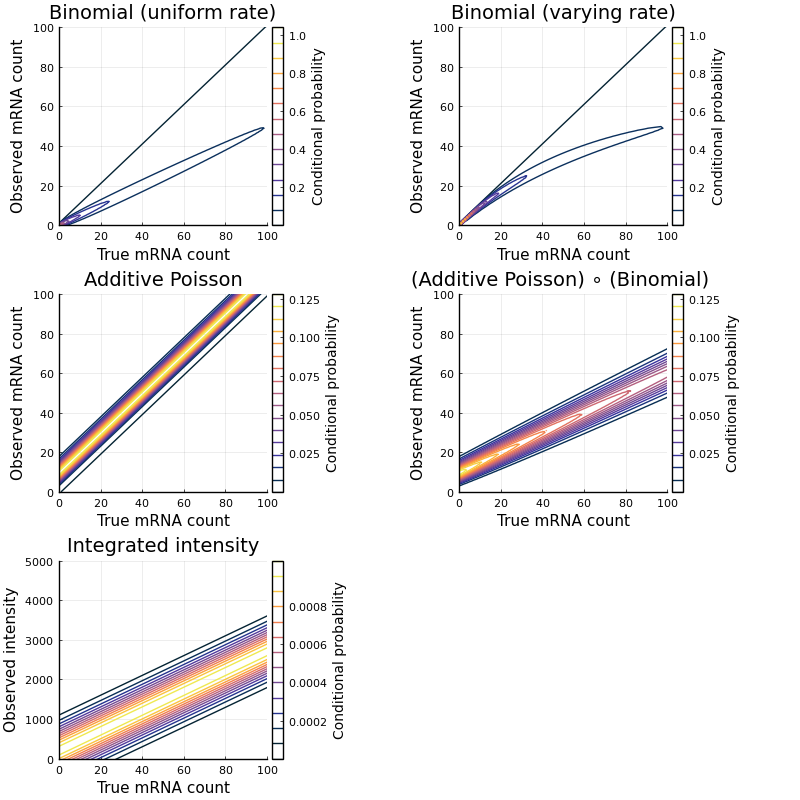

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [4]:
measurements = ["binomial", "binomial_state_dep", "poisson", "binomial_poisson", "flowcyt"]
PDOs = Dict()
xranges = Dict()
yranges = Dict()
for meas in measurements
    PDOs[meas], xranges[meas],yranges[meas] = let f = load(joinpath(@__DIR__, "./results/distortion_matrix_$(meas).jld2"))
        f["C"], f["xrange"],f["yrange"]
    end
end

meas_titles = Dict([
    "binomial" => "Binomial (uniform rate)",
    "binomial_state_dep" => "Binomial (varying rate)",
    "binomial_poisson" => "(Additive Poisson) ∘ (Binomial) ",
    "poisson" => "Additive Poisson",
    "flowcyt" => "Integrated intensity"
])

layout = @layout [a b;c d; e _]
subplots = []
for meas in measurements
    push!(subplots,
        contour(xranges[meas], yranges[meas], PDOs[meas],
            c=cgrad(:thermal),
            xlim=[0, 100], ylim=[0,100], clim=(1.0E-4,Inf),
            # colorbar_scale=:log10,
            colorbar_limit=(1.0E-4,Inf),
            colorbar_formatter=:auto,
            colorbar_title="Conditional probability",
            xlabel="True mRNA count", ylabel="Observed mRNA count",
            title = meas_titles[meas]
            )
    )
end
ylims!(subplots[end],0, 5000)
ylabel!(subplots[end],"Observed intensity")
plot(subplots..., layout=layout, size=(800, 800))

## Optimizing sampling period for data taken under different distortions

In [5]:
import PyPlot as Plt

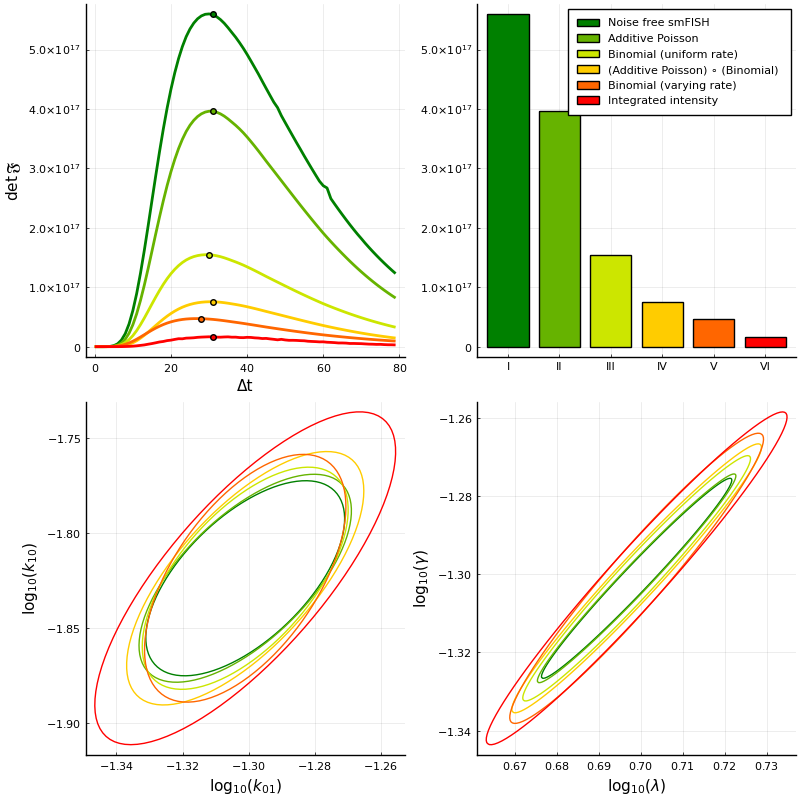

In [37]:
measurements = ["exact", "binomial", "binomial_state_dep", "poisson", "binomial_poisson", "flowcyt"]
opt_rates, multipletime_fims, multipletime_fim_dets = let f = load(joinpath(@__DIR__, "./results/opt_sampling_periods.jld2"))
    f["opt_rates"], f["multipletime_fims"], f["multipletime_fim_dets"]
end

romans = ["I", "II", "III", "IV", "V", "VI", "VII", "VIII", "IX", "X"]

meas_titles = Dict([
    "exact" => "Noise free smFISH",
    "binomial" => "Binomial (uniform rate)",
    "binomial_state_dep" => "Binomial (varying rate)",
    "binomial_poisson" => "(Additive Poisson) ∘ (Binomial) ",
    "poisson" => "Additive Poisson",
    "flowcyt" => "Integrated intensity"
])

# We sort the measurements by their best D-opt values so we can assign descending colors 
dopt_vals = [multipletime_fim_dets[meas][opt_rates[meas]] for meas in measurements]
idxs = sortperm(dopt_vals, rev=true)
measurements = measurements[idxs]
dopt_vals = dopt_vals[idxs]

p1 = plot()
cs = cgrad([:green, :yellow, :red], 6, categorical=true)
for (i,meas) in enumerate(measurements)
    plot!(p1, 0:length(multipletime_fim_dets[meas])-1, multipletime_fim_dets[meas],label=meas_titles[meas]*" ($(romans[i]))", color=cs[i],lw=2,legend=false)
    scatter!(p1, [opt_rates[meas]], [multipletime_fim_dets[meas][opt_rates[meas]]],label="", color=cs[i])
end
xlabel!(p1, "Δt")
ylabel!(p1, "\$\\operatorname{det}𝔉\$")


p2 = plot() 
for (i, meas) in enumerate(measurements)
    bar!(p2, [i], [dopt_vals[i]], color=cs[i], label=meas_titles[meas], legend=false)
end
xticks!(p2, [i for i in 1:6], romans[1:6])
plot!(p2, legend_font_pointsize=8, legend=true)

θ = [kon, koff, α, γ]

p3 = plot()
for (i,meas) in enumerate(measurements)
    Δt = opt_rates[meas]
    confidence_ellipse!(p3, multipletime_fims[meas][:,:,Δt+1], 3, (1,2), log10.(θ);color=cs[i], ls=:solid, lw=4.0)
end
xlabel!(p3, "\$\\log_{10}(k_{01})\$")
ylabel!(p3, "\$\\log_{10}(k_{10})\$")

p4 = plot()
for (i,meas) in enumerate(measurements)
    Δt = opt_rates[meas]
    confidence_ellipse!(p4, multipletime_fims[meas][:,:,Δt+1], 3, (3,4), log10.(θ);color=cs[i], ls=:solid, lw=4.0)
end
xlabel!(p4, "\$\\log_{10}(\\lambda)\$")
ylabel!(p4, "\$\\log_{10}(\\gamma)\$")

l = @layout [a b;c d]
pmain = plot(p1, p2, p3, p4, layout=l, size=(800,800))


# Probe binding noise

## Probabilistic Distortion Operators for different probe concentration levels

In [59]:
probebinding_pdos, probebinding_levels = let f = load(joinpath(@__DIR__,"./results/smfish_probe_distortions.jld2"))
    f["pdos"], f["levels"]
end;

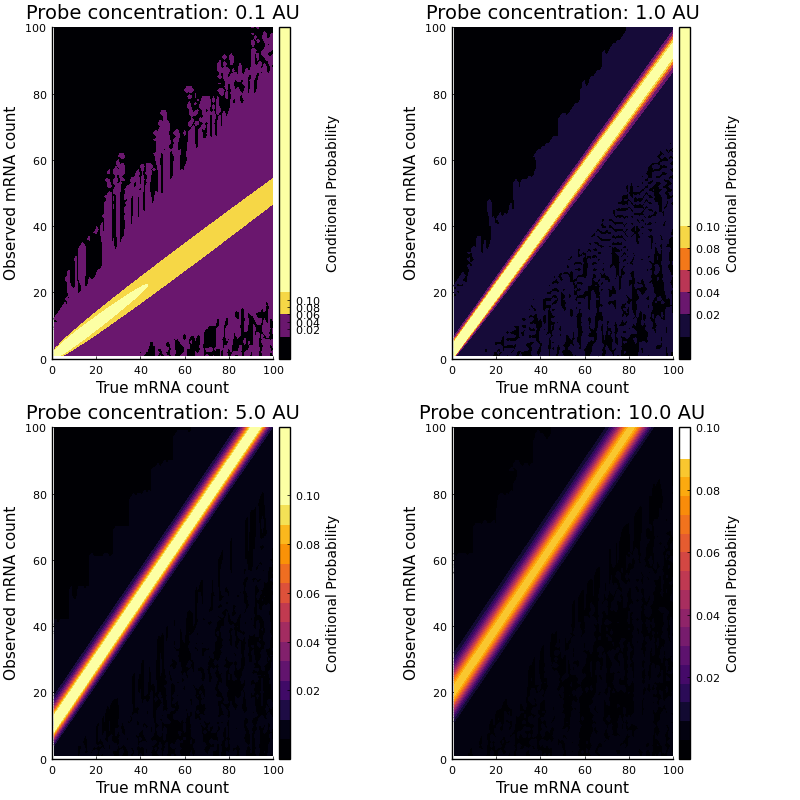

In [90]:
l = @layout [a b; c d]
pmain = plot(layout=l, size=(800, 800))
for (i, lev) in enumerate(probebinding_levels)
    contourf!(probebinding_pdos[lev], subplot=i,
        c=cgrad(scale=:log10),
        cscale=:log10,
        xlabel="True mRNA count", ylabel="Observed mRNA count", colorbar_title="Conditional Probability", clims=(1.0E-4,1E-1), colorbar_limits=(1.0E-4,1E-1),
        xlim=(0,100),ylim=(0,100),
        title="Probe concentration: $(lev) AU"
    )
end
pmain


## Optimizing sampling periods under different probe concentration levels

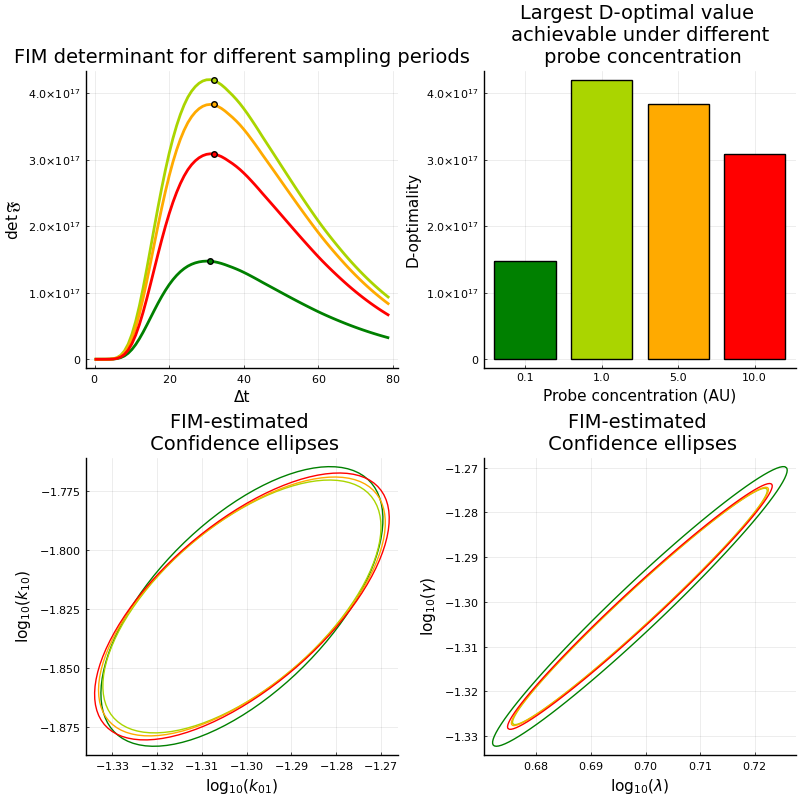

In [117]:
opt_dts, opt_fims, fim_dets, probebinding_levels = let f = load(joinpath(@__DIR__, "./results/smfish_probe_sweep.jld2"))
    f["optimal_dts"], f["optimal_fims"], f["fim_dets"], f["levels"]
end

p1 = plot()
cs = cgrad([:green, :yellow, :red], 4, categorical=true)
for (i,lev) in enumerate(probebinding_levels)
    plot!(p1, 0:length(fim_dets[i])-1, fim_dets[i],label="$(lev) AU", color=cs[i],lw=2,legend=false)
    scatter!(p1, [opt_dts[i]], [fim_dets[i][opt_dts[i]]],label="", color=cs[i])
end
title!(p1, "FIM determinant for different sampling periods")
xlabel!(p1, "Δt")
ylabel!(p1, "\$\\operatorname{det}𝔉\$")

p2 = plot() 
dopt_vals = [fim_dets[i][opt_dts[i]] for i in 1:length(fim_dets)]
for (i, lev) in enumerate(probebinding_levels)
    bar!(p2, [i], [dopt_vals[i]], color=cs[i], legend=false)
end
title!(p2, "Largest D-optimal value \n achievable under different \n probe concentration")
xticks!(p2, [i for i in 1:4], ["$lev" for lev in probebinding_levels])
xlabel!(p2, "Probe concentration (AU)")
ylabel!(p2, "D-optimality")
plot!(p2)

θ = [kon, koff, α, γ]

p3 = plot()
for (i,lev) in enumerate(probebinding_levels)
    Δt = opt_dts[i]
    confidence_ellipse!(p3, opt_fims[i], 3, (1,2), log10.(θ);color=cs[i], ls=:solid, lw=4.0)
end
title!(p3, "FIM-estimated \n Confidence ellipses")
xlabel!(p3, "\$\\log_{10}(k_{01})\$")
ylabel!(p3, "\$\\log_{10}(k_{10})\$")

p4 = plot()
for (i,lev) in enumerate(probebinding_levels)
    Δt = opt_dts[i]
    confidence_ellipse!(p4, opt_fims[i], 3, (3,4), log10.(θ);color=cs[i], ls=:solid, lw=4.0)
end
title!(p4, "FIM-estimated \n Confidence ellipses")
xlabel!(p4, "\$\\log_{10}(\\lambda)\$")
ylabel!(p4, "\$\\log_{10}(\\gamma)\$")

l = @layout [a b;c d]
pmain = plot(p1, p2, p3, p4, layout=l, size=(800,800))